In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_auc_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Set random seed
RANDOM_SEED = 42

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 128
OPTIMIZER = 'adam'
LOSS = 'mse'
DIM_ENCODER = 32

# Directories for saving artifacts
MODEL_SAV_DIR = "./models"
PLOTS_DIR = "./plots"
os.makedirs(MODEL_SAV_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)


In [2]:
# Load your dataset
data = pd.read_csv('creditcard.csv')

# Preprocess: drop 'Time', scale 'Amount'
def preprocess_data(df):
    df = df.drop('Time', axis=1)
    df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
    return df

data = preprocess_data(data)

# Separate features (X) and target (y)
X_full = data.drop('Class', axis=1).values
y_full = data['Class'].values

# Split into train & test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=RANDOM_SEED
)

# For autoencoder training, keep only normal transactions in X_train
X_train = X_train_full[y_train_full == 0]

print("Training set (only normal):", X_train.shape)
print("Test set (mixed):", X_test.shape)


Training set (only normal): (227451, 29)
Test set (mixed): (56962, 29)


Epoch 1/50
1773/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8316
Epoch 1: val_loss improved from inf to 0.69865, saving model to ./models\trained_model.keras
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8314 - val_loss: 0.6987
Epoch 2/50
1775/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6422
Epoch 2: val_loss improved from 0.69865 to 0.67132, saving model to ./models\trained_model.keras
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6422 - val_loss: 0.6713
Epoch 3/50
1759/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6264
Epoch 3: val_loss improved from 0.67132 to 0.65931, saving model to ./models\trained_model.keras
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6265 - val_loss: 0.6593
Epoch 4/50
1760/1777 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6203
Epoch 4: val_loss improved from 0.65931 to 0.64262, saving model to ./models\trained_model.keras
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6203 - val_loss: 0.6426
Epoch 5/50
1769/1777 ━━━━━━━━━━━

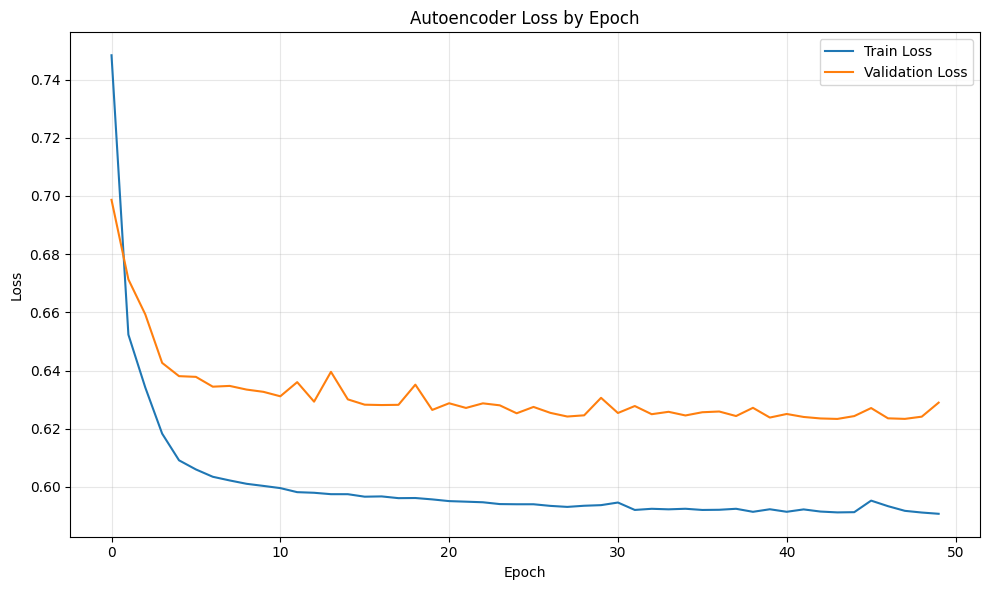

In [3]:
def build_autoencoder(input_dim):
    inp = Input(shape=(input_dim,))
    # Encoder
    encoded = Dense(DIM_ENCODER, activation='tanh',
                    activity_regularizer=regularizers.l1(1e-5))(inp)
    encoded = Dense(DIM_ENCODER//2, activation='relu')(encoded)
    # Decoder
    decoded = Dense(DIM_ENCODER//2, activation='tanh')(encoded)
    decoded = Dense(input_dim, activation='relu')(decoded)
    autoencoder = Model(inputs=inp, outputs=decoded)
    return autoencoder

# Instantiate and compile
autoencoder = build_autoencoder(X_train.shape[1])
autoencoder.compile(optimizer=OPTIMIZER, loss=LOSS)

# Callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(MODEL_SAV_DIR, "trained_model.keras"),
    verbose=1,
    save_best_only=True
)
tensorboard_cb = TensorBoard(log_dir='./logs')

# Train autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[checkpoint_cb, tensorboard_cb],
    verbose=1
)

# Plot training vs validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

loss_plot_path = os.path.join(PLOTS_DIR, "Loss_Curves.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Selected threshold for recall >= 0.9: 0.026517
Recall at this threshold: 1.0000
Precision at this threshold: 0.0017
Confusion Matrix:
 [[    1 56863]
 [    0    98]]
AUC Score: 0.5000087929093979
F1 Score: 0.0034350409225538483


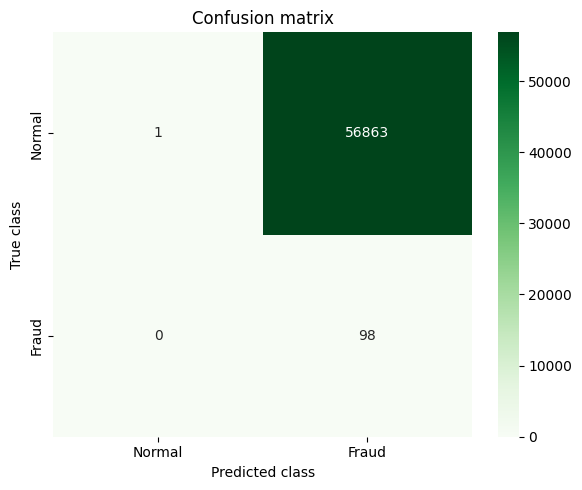

In [4]:
# 1) Get predictions (reconstructed samples) for the test set
test_predictions = autoencoder.predict(X_test)

# 2) Compute reconstruction error (MSE)
mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

# 3) Use precision_recall_curve to find the threshold that meets your desired recall
desired_recall = 0.90  # or 0.95, 0.99, etc.
precision, recall, thresholds = precision_recall_curve(y_test, mse)

# We'll find the first threshold index where recall >= desired_recall
idx = np.argmax(recall >= desired_recall)

# Handle edge case if we never reach that recall
if idx == 0 and recall[idx] < desired_recall:
    print(f"Warning: Could not find recall >= {desired_recall}. Highest recall = {recall.max():.2f}")
    best_threshold = thresholds[-1]  # fallback to last threshold
    idx = len(thresholds) - 1
else:
    best_threshold = thresholds[idx]

print(f"Selected threshold for recall >= {desired_recall}: {best_threshold:.6f}")
print(f"Recall at this threshold: {recall[idx]:.4f}")
print(f"Precision at this threshold: {precision[idx]:.4f}")

# 4) Classify based on best_threshold
y_pred = [1 if e > best_threshold else 0 for e in mse]

# 5) Evaluate
cnf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", cnf_matrix)
print("AUC Score:", auc_score)
print("F1 Score:", f1)

# 6) Plot confusion matrix
import itertools

plt.figure(figsize=(6,5))
# Using a green colormap for variety
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()

cm_plot_path = os.path.join(PLOTS_DIR, f"Confusion_Matrix_{desired_recall:.2f}.png")
plt.savefig(cm_plot_path, dpi=300)
plt.show()
